VL EADV, WS 2025/26, TU Bergakademie Freiberg

# Maschinelles Lernen mit NumPy, Matplotlib und Scikit-learn

Dieses Notebook zeigt einen kompletten Workflow für Maschinelles Lernen (ML) zur Klassifikation mit dem Iris-Datensatz. Wir behandeln Datenexploration, Modelltraining, Vorhersagen und Evaluierung.

## 1. Erforderliche Bibliotheken importieren

Wir importieren NumPy für numerische Operationen, Matplotlib für Visualisierungen sowie scikit-learn für Werkzeuge des maschinellen Lernens.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris  # Iris dataset for classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

## 2. Beispieldatensatz laden

Wir laden den klassischen Iris-Datensatz (enthalten in scikit-learn), der Messungen von Iris-Blüten enthält.

Der Datensatz beschreibt je 50 Exemplare von drei Sorten Schwertlilien:
- Iris Setosa (Borsten-Schwertlilie)
- Iris Versicolor (Verschiedenfarbige Schwertlilie)
- Iris Virginica (Virginische Schwertlilie)

Jedes Exemplar wird über vier Merkmale (Features) beschrieben:
- *sepal length*: Länge der Kelchblätter (Sepalen)
- *sepal width*: Breite der Kelchblätter
- *petal length*: Länge der Kronblätter (Petalen)
- *petal width*: Breite  der Kronblätter

Ziel des Maschinellen Lernes ist das Lernen eines Klassifikators:
- gegeben: eine Beschreibung einer Blüte mittels der vier Merkmale
- bestimme: die Sorte (Klasse) der Iris

In [ ]:
# Load the Iris dataset
iris = load_iris()
X = iris.data     # feature matrix, each row describes a sample with 4 features
y = iris.target   # class labels

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Feature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")
print(f"\nFirst 10 samples:")
print(X[:10])

Dataset shape: (150, 4)
Number of classes: 3
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

First 10 samples:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


## 3. Daten explorieren und visualisieren

Visualisierungen helfen dabei, die Datenverteilung und Beziehungen zwischen Merkmalen (Features) zu verstehen.

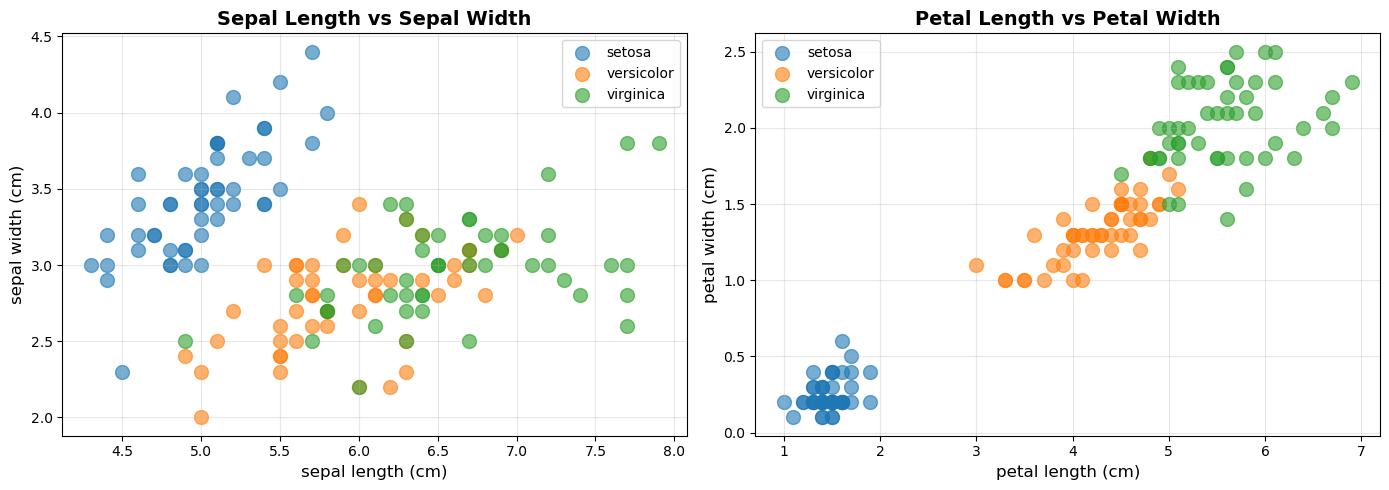

In [53]:
# Create scatter plot of two features colored by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Sepal length vs Sepal width
for i, target in enumerate(np.unique(y)):
    indices = (y == target)  # array of booleans where class matches
    axes[0].scatter(X[indices, 0], X[indices, 1], label=iris.target_names[target], s=100, alpha=0.6)

axes[0].set_xlabel(iris.feature_names[0], fontsize=12)
axes[0].set_ylabel(iris.feature_names[1], fontsize=12)
axes[0].set_title('Sepal Length vs Sepal Width', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: Petal length vs Petal width
for i, target in enumerate(np.unique(y)):
    indices = y == target
    axes[1].scatter(X[indices, 2], X[indices, 3], label=iris.target_names[target], s=100, alpha=0.6)

axes[1].set_xlabel(iris.feature_names[2], fontsize=12)
axes[1].set_ylabel(iris.feature_names[3], fontsize=12)
axes[1].set_title('Petal Length vs Petal Width', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

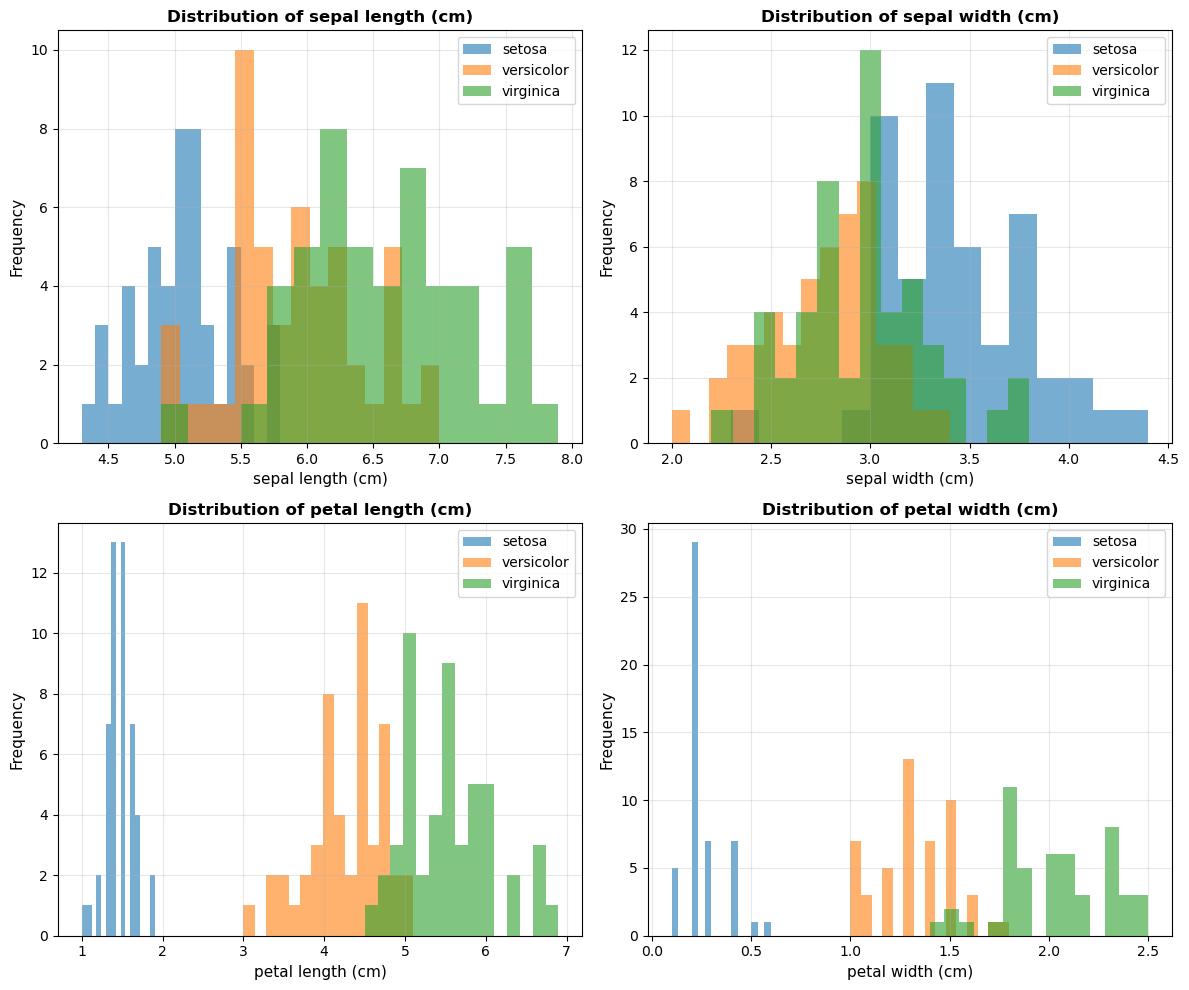

In [62]:
# Histogram of each feature
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # flatten 2D array of axes to 1D for easy iteration with a single loop

for i in range(4):
    for target in np.unique(y):
        indices = (y == target)  # array of booleans where class matches
        axes[i].hist(X[indices, i], label=iris.target_names[target], alpha=0.6, bins=15)
    
    axes[i].set_xlabel(iris.feature_names[i], fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(f'Distribution of {iris.feature_names[i]}', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Daten für das Modelltraining vorbereiten

### Aufteilung der Daten in Trainings- und Testsets

Ziel des Maschinellen Lernens ist in diesem Fall ein Klassfikator, der unbekannte, bislang nicht gesehene Exemplare von Pflanzen klassifizieren kann. In unserem Datensatz ist die Klasse aller Exemplare schon bekannt und müsste eigentlich nicht gelernt werden, aber der eigentliche Anwendungsfall sind natürlich zukünftige Messungen. Zum Training des Klassifikators verwenden wir einen "Trick": Wir nutzen nur einen Teil des Datensatzes zum Training, den anderen Teil des Datensatzes nutzen wir zum Testen des gelernten Klassifikators, indem wir die Vorhersagen des Klassifikators mit den bekannten korrrekten Klassen vergleichen.

Der Datensatz wird aufgeteilt in:
- **Trainingsset (70%)**: Wird verwendet, um das Modell zu trainieren
- **Testset (30%)**: Wird verwendet, um die Leistung des Modells zu evaluieren

### Feature-Skalierung (Feature Scaling)

**Was ist Feature-Skalierung?**

Feature-Skalierung ist ein Vorverarbeitungsschritt, bei dem die Wertebereiche aller Eingabemerkmale (Features) auf eine ähnliche Skala gebracht werden.

**Warum ist Feature-Skalierung wichtig?**

1. **Unterschiedliche Messskalen**: In unserem Iris-Datensatz haben alle Features ähnliche Wertebereiche (ca. 0–8 cm). Aber in anderen Datensätzen können Features völlig unterschiedliche Skalen haben:

   - Beispiel: Alter (0–100 Jahre) vs. Einkommen (0–1.000.000€)


2. **Algorithmen sind skalenabhängig**: Viele maschinelle Lernalgorithmen (wie Logistic Regression, SVM, KNN) basieren auf Distanzberechnungen. Sie funktionieren besser, wenn alle Features auf einer ähnlichen Skala liegen.

3. **Numerische Stabilität**: Features mit großen Wertebereichen können zu numerischen Problemen während des Trainings führen.

**Standardisierung (StandardScaler)**

Die Standardisierung transformiert jedes Feature so, dass es einen **Mittelwert von 0** und eine **Standardabweichung von 1** hat:

$$z = \frac{x - \text{mean}(x)}{\text{std}(x)}$$

Wobei:
- $x$ der ursprüngliche Wert ist
- $\text{mean}(x)$ der Mittelwert des Features ist  
- $\text{std}(x)$ die Standardabweichung des Features ist
- $z$ der skalierte Wert ist

**Wichtig**: Die Skalierungsparameter (Mittelwert und Standardabweichung) werden auf dem **Trainingssatz** berechnet und dann auf den **Testsatz** angewendet. Dies verhindert **Data Leakage** und stellt sicher, dass der Test eine echte Evaluierung des Modells darstellt.

In [55]:
# Split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled successfully!")
print(f"Mean of scaled training data: {X_train_scaled.mean(axis=0).round(4)}")
print(f"Std of scaled training data: {X_train_scaled.std(axis=0).round(4)}")

Training set size: 105
Testing set size: 45

Features scaled successfully!
Mean of scaled training data: [ 0. -0. -0.  0.]
Std of scaled training data: [1. 1. 1. 1.]


## 5. Maschinelles Lernmodell trainieren

Wir trainieren einen Logistic-Regression-Klassifikator auf den skalierten Trainingsdaten.

In [56]:
# Instantiate and train Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=42)  # Instantiate model
model.fit(X_train_scaled, y_train)     # Train the model

print("Model trained successfully!")
print(f"Number of classes: {len(model.classes_)}")
print(f"Classes: {model.classes_}")

Model trained successfully!
Number of classes: 3
Classes: [0 1 2]


## 6. Vorhersagen treffen

Wie verwenden das trainierte Modell, um Vorhersagen auf den Testdaten zu treffen.

In [57]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)

for i, target in enumerate(iris.target_names):
    print(f"{i}:{target}", end='   ')
print()
print(f"First 10 predictions:   {y_pred[:10]}")
print(f"First 10 actual values: {y_test[:10]}")

# Get prediction probabilities (logistic regression computes probabilities for each class)
y_pred_proba = model.predict_proba(X_test_scaled)
print(f"\nPrediction probabilities for first 5 samples:")
print(y_pred_proba[:5].round(3))

0:setosa   1:versicolor   2:virginica   
First 10 predictions:   [1 0 2 1 1 0 1 2 1 1]
First 10 actual values: [1 0 2 1 1 0 1 2 1 1]

Prediction probabilities for first 5 samples:
[[0.013 0.862 0.126]
 [0.968 0.032 0.   ]
 [0.    0.004 0.996]
 [0.015 0.737 0.248]
 [0.002 0.73  0.268]]


## 7. Modellleistung evaluieren

Die Modellleistung wird mittels verschiedener Metriken berechnet.

### Accuracy (Genauigkeit)

**Definition**: Die Accuracy gibt den Anteil der korrekt klassifizierten Beispiele an der Gesamtzahl aller Beispiele an.

$$\text{Accuracy} = \frac{\text{Anzahl korrekter Vorhersagen}}{\text{Gesamtzahl der Vorhersagen}} = \frac{TP + TN}{TP + TN + FP + FN}$$

Wobei:
- **TP** (True Positives): Korrekt als positiv klassifiziert
- **TN** (True Negatives): Korrekt als negativ klassifiziert  
- **FP** (False Positives): Fälschlicherweise als positiv klassifiziert
- **FN** (False Negatives): Fälschlicherweise als negativ klassifiziert

**Beispiel**: Bei 100 Vorhersagen werden 95 korrekt klassifiziert → Accuracy = 95/100 = 0.95 = 95%

**Vorteile**:
- Einfach zu verstehen und zu interpretieren
- Gibt einen schnellen Überblick über die Gesamtleistung

**Nachteile**:
- Bei **unbalancierten Datensätzen** kann Accuracy irreführend sein
- Beispiel: Wenn 95% der Daten zu Klasse A gehören, erreicht ein "dummes" Modell, das immer A vorhersagt, bereits 95% Accuracy, ist aber praktisch nutzlos

**Wann verwenden?**  
Accuracy eignet sich gut für balancierte Datensätze (alle Klassen etwa gleich häufig) und wenn falsch-positive und falsch-negative Fehler gleich wichtig sind.

### Weitere Metriken

- **Precision (Präzision)**: Von allen als positiv klassifizierten Beispielen, wie viele sind tatsächlich positiv?
- **Recall (Sensitivität)**: Von allen tatsächlich positiven Beispielen, wie viele wurden korrekt erkannt?
- **F1-Score**: Harmonisches Mittel von Precision und Recall

In [58]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Model Performance Metrics:")
print(f"Accuracy:  {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-Score:  {f1:.2%}")



Model Performance Metrics:
Accuracy:  100.00%
Precision: 100.00%
Recall:    100.00%
F1-Score:  100.00%


### Confusion Matrix (Konfusionsmatrix)

**Definition**: Eine Confusion Matrix ist eine Tabelle, die die Vorhersagen eines Klassifikationsmodells mit den tatsächlichen Klassen vergleicht. Sie zeigt, wie oft das Modell richtig und falsch klassifiziert hat.

**Aufbau der Confusion Matrix**:

Für ein **binäres Klassifikationsproblem** (2 Klassen):

```
                    Vorhergesagt
                    Negativ  Positiv
Tatsächlich  Negativ   TN       FP
             Positiv   FN       TP
```

- **True Negative (TN)**: Korrekt als negativ klassifiziert
- **False Positive (FP)**: Fälschlich als positiv klassifiziert (Fehler Typ I)
- **False Negative (FN)**: Fälschlich als negativ klassifiziert (Fehler Typ II)  
- **True Positive (TP)**: Korrekt als positiv klassifiziert

**Für unser Iris-Problem** (3 Klassen, Testset mit 45 Beispielen):

Die Matrix ist 3×3, wobei:
- **Zeilen**: Tatsächliche Klassen (Setosa, Versicolor, Virginica)
- **Spalten**: Vorhergesagte Klassen

**Interpretation**:
- **Diagonale**: Korrekte Vorhersagen (die Zahl zeigt, wie viele Beispiele jeder Klasse richtig klassifiziert wurden)
- **Außerhalb der Diagonale**: Fehler (z.B. ein Versicolor wurde fälschlich als Virginica klassifiziert)

**Beispiel-Matrix**:
```
              Setosa  Versicolor  Virginica
Setosa          19        0          0
Versicolor       0       13          0  
Virginica        0        0         13
```

Diese perfekte Matrix zeigt: Alle 19 Setosa wurden korrekt als Setosa erkannt, alle 13 Versicolor korrekt als Versicolor, usw.

**Vorteile**:
- Zeigt detailliert, welche Fehler das Modell macht
- Hilft zu verstehen, ob bestimmte Klassen verwechselt werden
- Grundlage für die Berechnung von Precision, Recall und F1-Score

**Praktischer Nutzen**: Wenn z.B. Versicolor oft mit Virginica verwechselt wird, könnte das bedeuten, dass diese beiden Arten sehr ähnliche Merkmale haben und das Modell mehr Trainingsbeispiele oder bessere Features braucht.

In [59]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


Wir haben also einen perfekten Klassifikator trainiert! In komplexeren Datensätzen wird dies aber typischerweise nicht der Fall sein und wir müssen uns mit etwas geringen Klassifikatorleistungen zufrieden geben.

## 8. Modellergebnisse visualisieren

Zum Schluss erstellen wir noch Visualisierungen, um Modellvorhersagen und -leistung grafisch darzustellen.

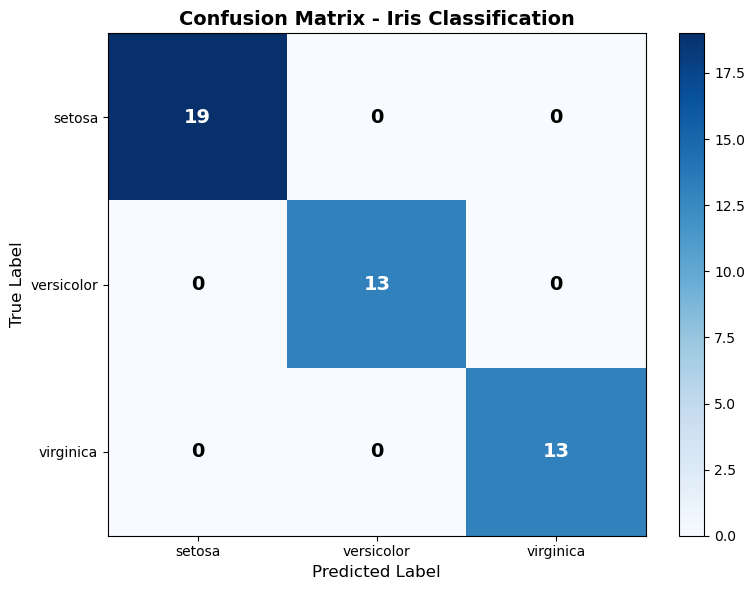

In [60]:
# Visualize Confusion Matrix using matplotlib only
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap using imshow
im = ax.imshow(cm, cmap='Blues', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)

# Set ticks and labels
ax.set_xticks(np.arange(len(iris.target_names)))
ax.set_yticks(np.arange(len(iris.target_names)))
ax.set_xticklabels(iris.target_names)
ax.set_yticklabels(iris.target_names)

# Add text annotations
for i in range(len(iris.target_names)):
    for j in range(len(iris.target_names)):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white",
                      fontsize=14, fontweight='bold')

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - Iris Classification', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

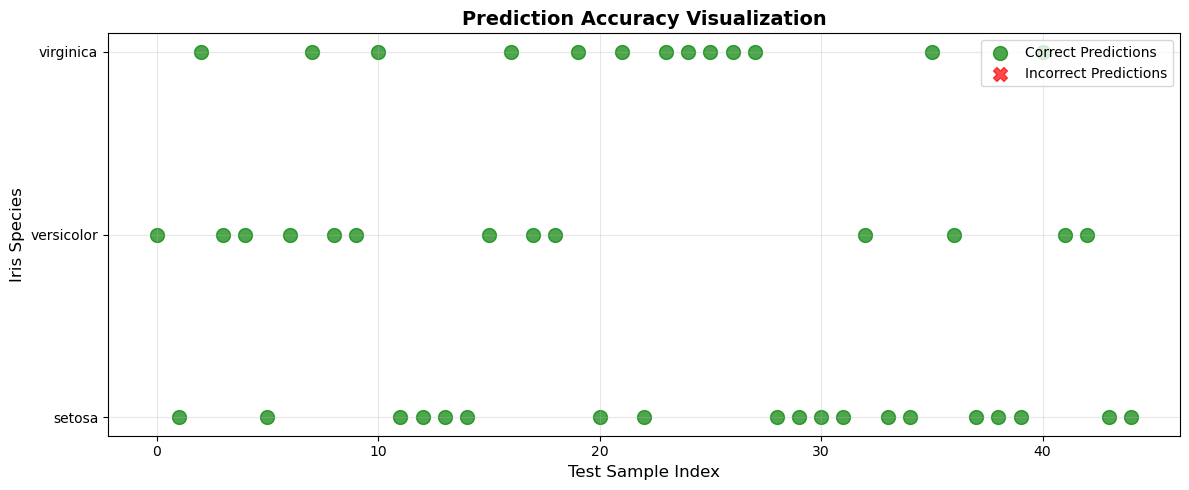


Total predictions: 45
Correct: 45
Incorrect: 0


In [61]:
# Visualize predictions vs actual values
fig, ax = plt.subplots(figsize=(12, 5))

x_pos = np.arange(len(y_test))
width = 0.35

# Create a simple visualization showing correct vs incorrect predictions
correct = (y_test == y_pred)  # array of booleans indicating correct predictions
colors = ['green' if c else 'red' for c in correct]

ax.scatter(x_pos[correct], y_test[correct], color='green', s=100, alpha=0.7, label='Correct Predictions')
ax.scatter(x_pos[~correct], y_test[~correct], color='red', s=100, alpha=0.7, marker='X', label='Incorrect Predictions')

ax.set_xlabel('Test Sample Index', fontsize=12)
ax.set_ylabel('Iris Species', fontsize=12)
ax.set_title('Prediction Accuracy Visualization', fontsize=14, fontweight='bold')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(iris.target_names)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal predictions: {len(y_test)}")
print(f"Correct: {correct.sum()}")
print(f"Incorrect: {(~correct).sum()}")

In [31]:
# Per-class performance metrics
from sklearn.metrics import classification_report

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



# 9. Zusammenfassung

Wir haben einen vollständigen Workflow für das Maschinelle Lernen gesehen und einen Klassifikator für den wohlbekannten Iris-Datensatz (aus dem Jahr 1936 stammend) trainiert.

In unserem Beispiel haben wir mit der logistischen Regression ein klassisches statistisches Modell trainiert. Ein heißes Thema sind zur Zeit tiefe neuronale Netze (Deep Learning), die für komplexere Datensätze und Lernaufgaben genutzt werden. Der allgemeine Workflow ist dabei oft sehr ähnlich, es müsste im einfachsten Fall nur ein anderes Modell zum Trainieren ausgewählt werden (in Schritt 5 wenige Zeilen Code ändern).

Python ist eine sehr beliebte Programmiersprache für das Maschinelle Lernen. Bekannte Bibliotheken sind etwa PyTorch, Tensorflow und Keras. Die ML-Algorithmen dieser Bibliotheken sind stark optimiert, laufen auch auf GPUs, und skalieren von Laptops bis zu Supercomputern.
